In [16]:

# Re-import dependencies (in case earlier import was skipped)
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

from permutationsga.ga import (
    ConfigurableGA,

    RandomPermutationInitialization,
    crossover_pmx,
    TournamentSelection,
    FunctionBasedRecombinator,
    SequentialSelector,
    generate_sequential_indices,
    
    
)
from permutationsga.problem import IdenticalDecoder, InvPermDecoder, RandomKeysDecoder

from permutationsga.qap import QAP, read_qaplib
from mutation_initialization.frequency_based_initialization import FrequencyBasedInitialization
from our_other_crossover.linkage_based_crossover import LinkageBasedCrossover

In [17]:
# The bur* instances are those that we will be using - note that we are only using 26 keys in this case.
problem = QAP(*read_qaplib("./instances/qap/bur26a.dat"))

In [18]:
distance_matrix = problem.A
frequency_matrix = problem.B

if distance_matrix[0][0] == 53:
    type = 0
if distance_matrix[0][0] == 37:
    type = 1
else:
    Exception("The distance matrix is not as expected")

row_sum = np.sum(frequency_matrix, axis = 1)
col_sum = np.sum(frequency_matrix, axis = 0)
frequencies = np.add(row_sum, col_sum)
high_frequency = np.argsort(frequencies)[-9:]
print(f"type: {type}, high frequency characters: {high_frequency}")

type: 0, high frequency characters: [11  7 18  0 19 17  8 13  4]


In [19]:
row_sum = np.sum(distance_matrix, axis = 1)
col_sum = np.sum(distance_matrix, axis = 0)
distances = np.add(row_sum, col_sum)
better_region = np.argsort(distances)[:8]
print(better_region)

[18 17 16 12 10 11  9 13]


In [20]:
problem = IdenticalDecoder(problem) 

Recombine & Select (repeat a few times to see how things evolve!):

In [21]:
def pass_matrices_to_crossover():
    return frequency_matrix, distance_matrix

In [22]:
differences = []
p = 1e-3
seed = 42
population_size = 2**11
rng = np.random.default_rng(seed=seed + 1)
l = problem.get_length()


crossover_fn = LinkageBasedCrossover().linkage_based_crossover
#initialization = FrequencyBasedInitialization(p, type, high_frequency)
initialization = RandomPermutationInitialization(l)
indices_gen = pass_matrices_to_crossover  # so that it gets passed to the crossover function
parent_selection = SequentialSelector()
recombinator = FunctionBasedRecombinator(
    indices_gen,
    crossover_fn,
    parent_selection,
    population_size * 2, # Note: double as we are including the previous population
    include_what="population"
)
selection = TournamentSelection()
ga = ConfigurableGA(
    seed, population_size, problem, initialization, recombinator, selection
)


In [23]:
i=0
while True:
    ga.generation()
    differences.append(max(s.f for s in ga.population) - min(s.f for s in ga.population))
    if differences[-1] == 0:
        break
    i+=1 

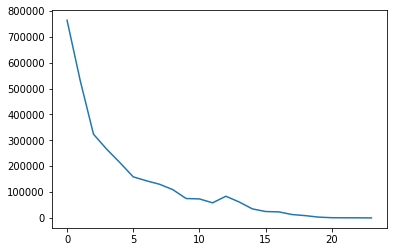

In [24]:
# plot the differences in plt.line
plt.plot(differences)

In [25]:
print(len(differences))

24


In [26]:
# Current best & worst
min(s.f for s in ga.population), max(s.f for s in ga.population)

(5462116.0, 5462116.0)

In [27]:
# print the genotype of the best
print(ga.population[np.argmin(s.f for s in ga.population)].e)

[12 10 21 22  5  6  3 20 14  0 18  7 17  2 13 24 19  8  4  9 25 23  1 11
 15 16]


In [33]:
from configs        import EA_Config, Exp_Config, rng, l
from run_experiment import run_experiments, round_to_multiple
from math       import ceil


p=1e-2

EA_Config(crossover_fn=crossover_pmx, indices_gen=lambda: generate_sequential_indices(rng, l), initialization=RandomPermutationInitialization(l))
EA_Config(crossover_fn=crossover_pmx, indices_gen=lambda: generate_sequential_indices(rng, l), initialization=FrequencyBasedInitialization(p, type, high_frequency, better_region))
EA_Config(crossover_fn=LinkageBasedCrossover().linkage_based_crossover, indices_gen=pass_matrices_to_crossover, initialization=RandomPermutationInitialization(l))
EA_Config(crossover_fn=LinkageBasedCrossover().linkage_based_crossover, indices_gen=pass_matrices_to_crossover, initialization=FrequencyBasedInitialization(p, type, high_frequency, better_region))

setups = {
    "Baseline"    : EA_Config(crossover_fn=crossover_pmx, indices_gen=lambda: generate_sequential_indices(rng, l), initialization=RandomPermutationInitialization(l))
,
    "Custom Initialisation" : EA_Config(crossover_fn=crossover_pmx, indices_gen=lambda: generate_sequential_indices(rng, l), initialization=FrequencyBasedInitialization(p, type, high_frequency, better_region))
, "Custom Crossover" : EA_Config(crossover_fn=LinkageBasedCrossover().linkage_based_crossover, indices_gen=pass_matrices_to_crossover, initialization=RandomPermutationInitialization(l))
, "Custom Initialisation and Crossover" : EA_Config(crossover_fn=LinkageBasedCrossover().linkage_based_crossover, indices_gen=pass_matrices_to_crossover, initialization=FrequencyBasedInitialization(p, type, high_frequency, better_region))
}

exp_cfg = Exp_Config("crossover_indices")

all_best_overtime, all_worst_overtime, all_iterations, all_total_times, all_iter_times = run_experiments(setups, exp_cfg)

colors = ["orange", "blue", "green", "purple"]

ncols = 2
nrows = 2

alltime_worst   = max([max(x) for x in all_worst_overtime])
alltime_best    = min([min(x) for x in all_best_overtime])



Custom Initialisation and Crossover


ValueError: max() arg is an empty sequence

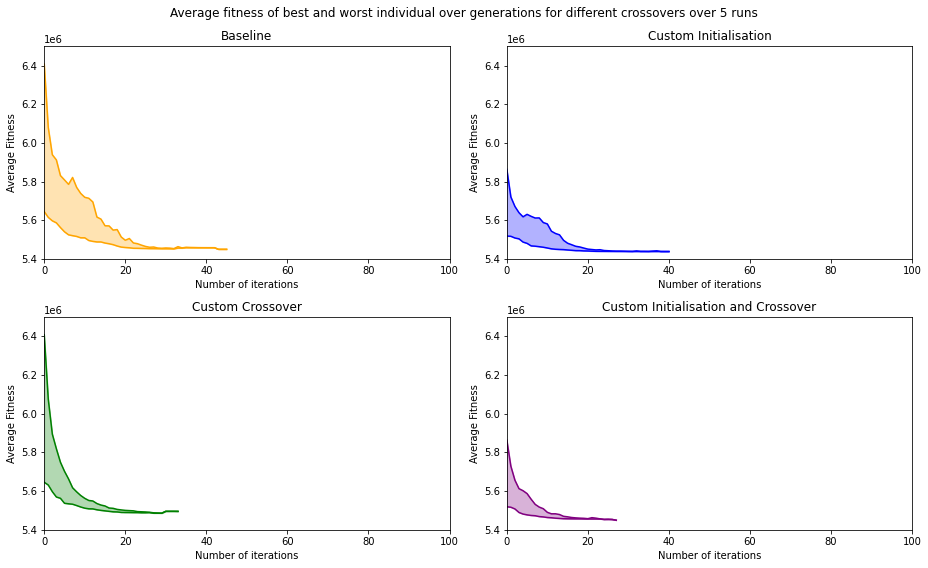

: 

: 

: 

In [ ]:
ylim_min = round_to_multiple(alltime_best,  100000, int)
ylim_max = round_to_multiple(alltime_worst, 100000, ceil)


fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(13, 8))


for i in range(ncols * nrows - len(setups)):
    i += len(setups)

    fig.delaxes(axes[i // ncols, i % ncols])

for i, (setup_name, best_overtime, worst_overtime, color) in enumerate(zip(setups.keys(), all_best_overtime, all_worst_overtime, colors)):
    ax = axes[i // ncols, i % ncols]
    
    ax.plot(best_overtime,  color=color)
    ax.plot(worst_overtime, color=color)
    ax.fill_between(np.arange(len(best_overtime)), best_overtime, worst_overtime, color=color, alpha=0.3)

    ax.set_ylabel("Average Fitness")
    ax.set_xlabel("Number of iterations")
    ax.set_xlim(0, exp_cfg.max_gen)
    ax.set_ylim(ylim_min, ylim_max)
    ax.set_title(setup_name)

plt.suptitle(f"Average fitness of best and worst individual over generations for different crossovers over {exp_cfg.n_experiments} runs")
fig.tight_layout()
plt.show()